# TIM - TP5 : Morphologie Mathématique

Aujourd'hui, place à la morphologie mathématique. C'est avant tout un ensemble de methodes pour le traitement de la forme des objets dans une image. L'objectif principal de cette famille d'algorithme est de supprimer le bruit introduit par des opérations de segmentation. On utilise donc souvent un algorithme MM en traitement ou en post-traitement.

## Ex. 0 : Quelques préparatifs avant le développement

Chargez l'image noisy_yin_yang.png en niveaux de gris, à télécharger sur Moodle et à insérer dans votre base d'images.

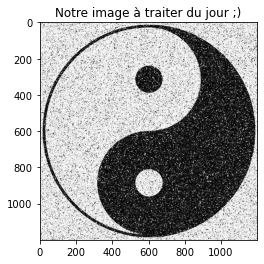

In [1]:
# A compléter
# Chargement des librairies
import cv2
from matplotlib import pyplot as plt
import numpy as np
import itertools
from scipy.ndimage.interpolation import shift
from utils import chronometrer,afficher

# Définition du chemin de la base d'images
path_base = '../Base_images/'

# Chargement de l'image et affichage
yinyang = cv2.imread(path_base+'noisy_yin_yang.png',0)
afficher(yinyang,'gray','Notre image à traiter du jour ;)')

Dans le cadre de la morphologie mathématique, il nous faut obligatoirement ce qu'on appelle un élément structurant ou kernel. C'est un tableau/masque binaire qui sera appliqué sur notre image à traiter en fonction de l'algorithme utilisé. Plusieurs tailles et formes de kernel existent ici. Au lieu de les fabriquer nous même, on va utiliser une superbe fonction d'OpenCV : getStructuringElement.

Avec cette fonction, construisez et affichez :
- Un kernel rectangulaire 5X5
- Un kernel elliptique 7X7
- Un kernel en croix 3x3
- Un kernel rectangulaire 3X11

<Figure size 432x288 with 0 Axes>

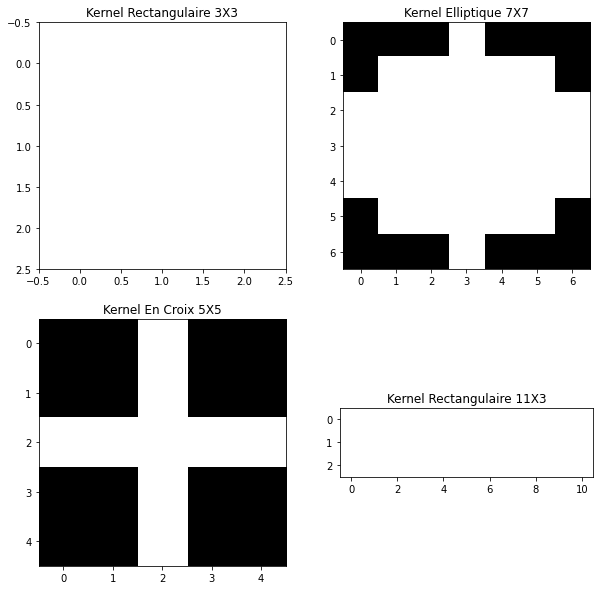

In [2]:
# A compléter
# Construction et affichage des kernels

plt.figure()

# Création d'un kernel rectangulaire 5X5
kernel_rect_3_3 = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))

# Création d'un kernel elliptique 7X7
kernel_ellipse_7_7 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))

# Création d'un kernel en croix 3X3
kernel_cross_5_5 = cv2.getStructuringElement(cv2.MORPH_CROSS,(5,5))

# Création d'un kernel rectangulaire 11X3
kernel_rect_11_3 = cv2.getStructuringElement(cv2.MORPH_RECT,(11,3))

plt.subplots(2,2,figsize=(10,10))
plt.subplot(221)
plt.imshow(kernel_rect_3_3,'gray',vmin=0,vmax=1)
plt.title('Kernel Rectangulaire 3X3')
plt.subplot(222)
plt.imshow(kernel_ellipse_7_7,'gray',vmin=0,vmax=1)
plt.title('Kernel Elliptique 7X7')
plt.subplot(223)
plt.imshow(kernel_cross_5_5,'gray',vmin=0,vmax=1)
plt.title('Kernel En Croix 5X5')
plt.subplot(224)
plt.imshow(kernel_rect_11_3,'gray',vmin=0,vmax=1)
plt.title('Kernel Rectangulaire 11X3')
plt.show()


## Ex. 1 : Développement des algorithmes de Morphologie Mathématique

**1.**

Commençons d'abord avec l'érosion. Dans le cadre des images binaires (notre cas ;) ), l'érosion d'une image I par un kernel K consiste en l'opération suivante :
                            
$ {\epsilon}_K(I) = \{ x|K_{x} \subset I \}$

C'est-à-dire, l'ensemble des points x tels que K soit totalement inclus dans I avec K centré en x.

Dans ce principe, développez la fonction d'érosion d'une image I par un kernel K.

In [3]:
def erosion(I,K):
    height,width = I.shape
    k_height,k_width = K.shape
    output = np.zeros((height,width),dtype=np.uint8)
    I_extended = np.zeros((height+k_height-1,width+k_width-1),dtype=np.uint8)
    I_extended[k_height//2:k_height//2+height,k_width//2:width+k_width//2]=I
    for i in range(height):
        for j in range(width):
            imagette = I_extended[i:k_height+i,j:k_width+j].astype(np.bool)
            output[i,j] = np.all(imagette[K.astype(np.bool)])
    return output

def erosion_faster(I,K):
    # On concatène plusieurs fois la même image mais avec un décalage. 
    # Si on a un filtre 5X5, on aura donc 25 images concatenées, avec un décalage en x allant de -2 à 2 et un décalage en y allant de -2 à 2.
    # Donc sur l'axe de concaténation, on obtient pour chaque position (x,y) un vecteur de taille 25 avec les valeurs correspondants à la fenêtre englobante.
    b=np.stack([shift(I.astype(np.uint8),(i-K.shape[0]//2,j-K.shape[1]//2),cval=np.NaN).astype(np.bool) for i,j in itertools.product(range(K.shape[0]),range(K.shape[1]))])
    # De ce vecteur, on va sélectionner uniquement les valeurs vraies (1) de l'élement structurant.
    a=b[K.astype(np.bool).reshape(-1),:,:]
    # Pour finir, sur cet axe de concaténation, on va vérifier que toutes les valeurs sont vraies (1) pour définir le pixel à vrai (1). Si ce n'est pas le cas, le pixel sera faux (0).
    return np.all(a,axis=0)

Appliquez l'érosion sur votre image bruitée avec le kernel en croix 5X5 et affichez le résultat. Analysez le résultat.

Temps d'exécution de Erosion : 17.13 sec
Temps d'exécution de Fast Erosion : 4.30 sec


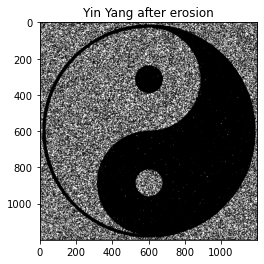

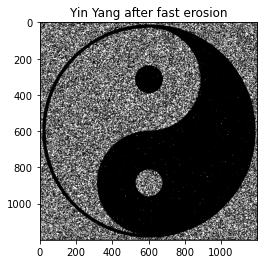

In [4]:
erode_yinyang = chronometrer(erosion,"Erosion",yinyang,kernel_cross_5_5)
erode_faster_yinyang = chronometrer(erosion_faster,"Fast Erosion",yinyang,kernel_cross_5_5)
afficher(erode_yinyang,'gray','Yin Yang after erosion')
afficher(erode_faster_yinyang,'gray','Yin Yang after fast erosion')

**_Réponse :_** Le bruit blanc a été très diminué (il reste quelques artefacts plus gros, donc utiliser un élément structurant plus gros pourrait permettre de tous les éliminer). Cependant, le bruit noir lui a été très amplifié, donc se limiter à cet algorithme pour réduire et le bruit noir, et le bruit blanc, n'est pas la solution.

---
**2.**

Passons maintenant à la dilatation. Dans le cadre des images binaires, la dilatation d'une image I par un kernel K consiste en l'opération suivante :

$ {\delta}_K(I) = \{ x|K_{x} \cap I \neq \emptyset \}$

C'est-à-dire, l'union ds points x tels que $K_{x}$ intersecte I avec K centré en x.

Dans ce principe, développez la fonction de dilatation d'une image I par un kernel K.

In [5]:
def dilatation(I,K):
    height,width = I.shape
    k_height,k_width = K.shape
    output = np.zeros((height,width),dtype=np.uint8)
    I_extended = np.zeros((height+k_height-1,width+k_width-1),dtype=np.uint8)
    I_extended[k_height//2:k_height//2+height,k_width//2:width+k_width//2]=I
    for i in range(height):
        for j in range(width):
            imagette = I_extended[i:k_height+i,j:k_width+j]
            output[i,j] = np.any(imagette[K.astype(np.bool)])
    return output

def dilatation_faster(I,K):
    # On concatène plusieurs fois la même image mais avec un décalage. 
    # Si on a un filtre 5X5, on aura donc 25 images concatenées, avec un décalage en x allant de -2 à 2 et un décalage en y allant de -2 à 2.
    # Donc sur l'axe de concaténation, on obtient pour chaque position (x,y) un vecteur de taille 25 avec les valeurs correspondants à la fenêtre englobante.
    b=np.stack([shift(I.astype(np.uint8),(i-K.shape[0]//2,j-K.shape[1]//2),cval=np.NaN).astype(np.bool) for i,j in itertools.product(range(K.shape[0]),range(K.shape[1]))])
    # De ce vecteur, on va sélectionner uniquement les valeurs vraies (1) de l'élement structurant.
    a=b[K.astype(np.bool).reshape(-1),:,:].astype(np.bool)
    # Pour finir, sur cet axe de concaténation, on va vérifier qu'au moins un pixel du vecteur est vrai (1) pour définir le pixel à vrai (1). Si ce n'est pas le cas, le pixel sera faux (0).
    return np.any(a,axis=0)

Appliquez la dilatation sur votre image bruitée avec le kernel en croix 5X5 et affichez le résultat. Analysez le résultat.

Temps d'exécution de Erosion : 16.84 sec
Temps d'exécution de Fast Erosion : 4.14 sec


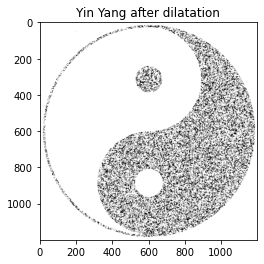

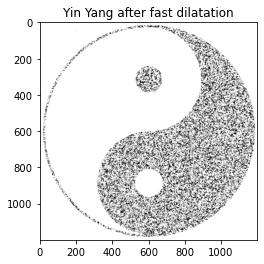

In [6]:
dilate_yinyang = chronometrer(dilatation,"Erosion",yinyang,kernel_cross_5_5)
dilate_faster_yinyang = chronometrer(dilatation_faster,"Fast Erosion",yinyang,kernel_cross_5_5)
afficher(dilate_yinyang,'gray','Yin Yang after dilatation')
afficher(dilate_faster_yinyang,'gray','Yin Yang after fast dilatation')

**_Réponse :_** Le bruit noir a été très diminué, comme précédemment, mais avec toujours quelques gros artefacts. Comme pour l'érosion, on a cette fois le bruit blanc qui lui a été très amplifié. Donc, comme pour l'érosion, se limiter à ce seul algorithme pour enlever un fort bruit sel et poivre n'est pas la meilleure idée.

---
**3.**

Passons à la vitesse supérieure ! Développez maintenant la fonction d'ouverture, qui consiste tout simplement d'une érosion puis d'une dilatation pour une image I avec un kernel K.

In [7]:
def opening(I,K):
    return dilatation_faster(erosion_faster(I,K),K)

Appliquez l'ouverture sur votre image bruitée avec le kernel en croix 5X5 et affichez le résultat. Analysez le résultat.

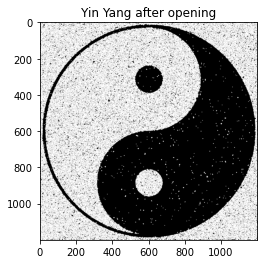

In [8]:
opened_yinyang = opening(yinyang,kernel_cross_5_5)
afficher(opened_yinyang,'gray','Yin Yang after opening')

**_Réponse :_** Grâce à l'ouverture, on a pu enlever une bonne partie du bruit blanc cette fois (même chose, il reste quelques gros artefacts, donc il faudrait appliquer un élement structurant plus gros). En revanche, le bruit noir lui n'a quasi pas changé : il est toujours là, mais il n'est pas plus important, comme on pouvait le voir lors de l'érosion. Pour éliminer le bruit blanc, l'ouverture est une très bonne option.

---
**4.**

Développez maintenant la fonction de fermeture, qui consiste tout simplement d'une dilatation suivie d'une érosion pour une image I avec un kernel K.

In [9]:
def closing(I,K):
    return erosion_faster(dilatation_faster(I,K),K)

Appliquez la fermeture sur votre image bruitée avec le kernel en croix 5X5 et affichez le résultat. Analysez le résultat.

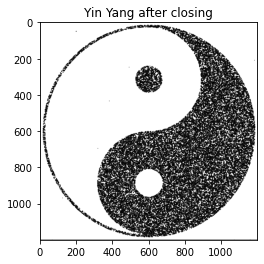

In [10]:
closed_yinyang = closing(yinyang,kernel_cross_5_5)
afficher(closed_yinyang,'gray','Yin Yang after closing')

**_Réponse :_** On obtient les mêmes conclusions que pour l'ouverture, mais cette fois, on a attenué fortement le bruit noir, tout en n'augmentant pas drastiquement le bruit blanc.

---
**5.**

Enfin, pour finir la partie développement, déveoppez la fonction de gradient morphologique, qui est la différence entre la dilatation et l'érosion d'une image I par un kernel K.

In [11]:
def morph_gradient(I,K):
    return dilatation_faster(I,K).astype(np.uint8)-erosion_faster(I,K).astype(np.uint8)

Appliquez l'ouverture sur votre image bruitée avec le kernel en croix 5X5 et affichez le résultat.

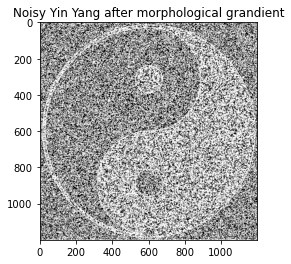

In [12]:
morph_grad_yinyang = morph_gradient(yinyang,kernel_cross_5_5)
afficher(morph_grad_yinyang,'gray','Noisy Yin Yang after morphological grandient')

Le résultat n'est pas terrible ? C'est normal, car notre image est assez bruitée, donc on ne voit pas l'intérêt du gradient morphologique. Essayez plutôt avec l'image yin_yang.png.

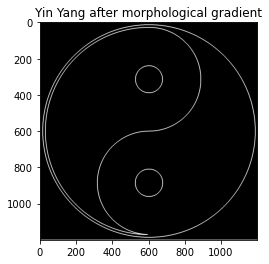

In [13]:
yinyang2 = cv2.imread(path_base+'yin_yang.png',0)
afficher(morph_gradient(yinyang2,kernel_cross_5_5),'gray','Yin Yang after morphological gradient')

## Ex. 2 : Bon, passons à un cas pratique maintenant ;)



Attention, cet exercice n'est pas évident. Cela veut dire qu'il n'y a pas une bonne solution, à vous de voir comment procéder pour atteindre votre objectif ! Bon courage ! *_Signé Robin du passé qui a passé un certain temps pour que l'exercice soit faisable..._*

Ici, on va prendre un cas pratique. Chargez l'image noisy_qrcode.png et affichez la.

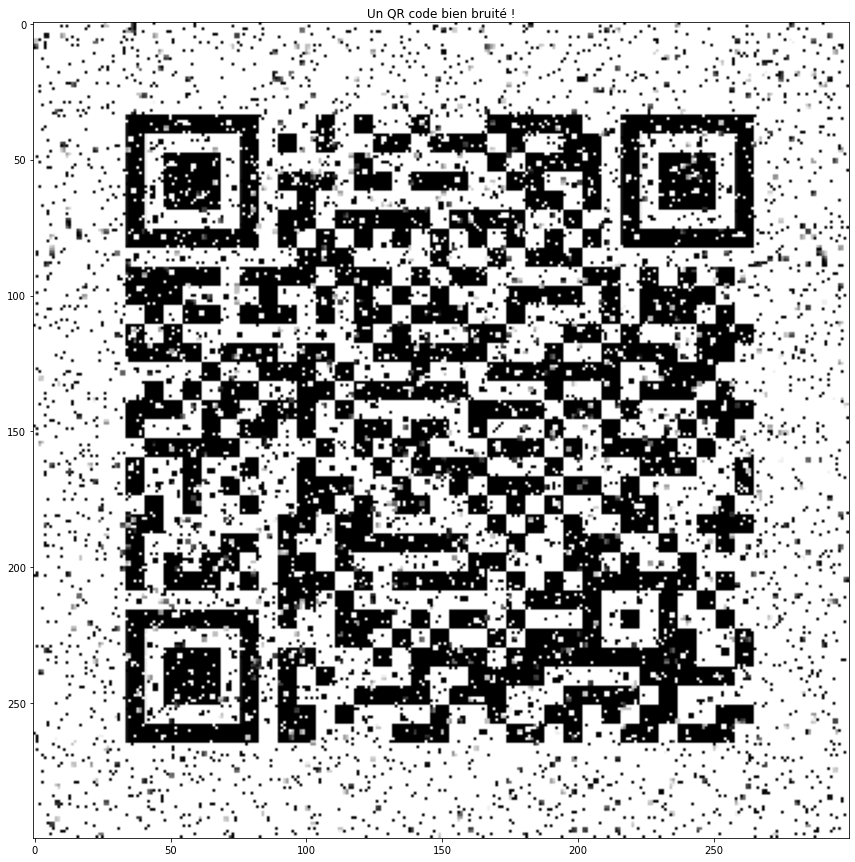

In [14]:
qrcode = cv2.imread(path_base+'QRcode.png',0)
afficher(qrcode,'gray',"Un QR code bien bruité !",figsize=(15,15))

Comme vous pouvez le voir, le QR code est assez bruité, et un scanner classique de QR code pourra difficilement identifier le QR code. L'objectif ici est donc d'améliorer la qualité du QR code en éliminant le bruit présent grâce aux algorithmes de Morphologie Mathématique vues précédemment. Histoire d'être un chouilla plus rapide dans l'exécution, je vous conseille fortement d'utiliser la fonction proposée par OpenCV : cv2.morphologyEx.

Pas de métrique, ni de comparaison de temps d'exécution cette fois, je veux juste que vous arriviez à scanner le QR code :D

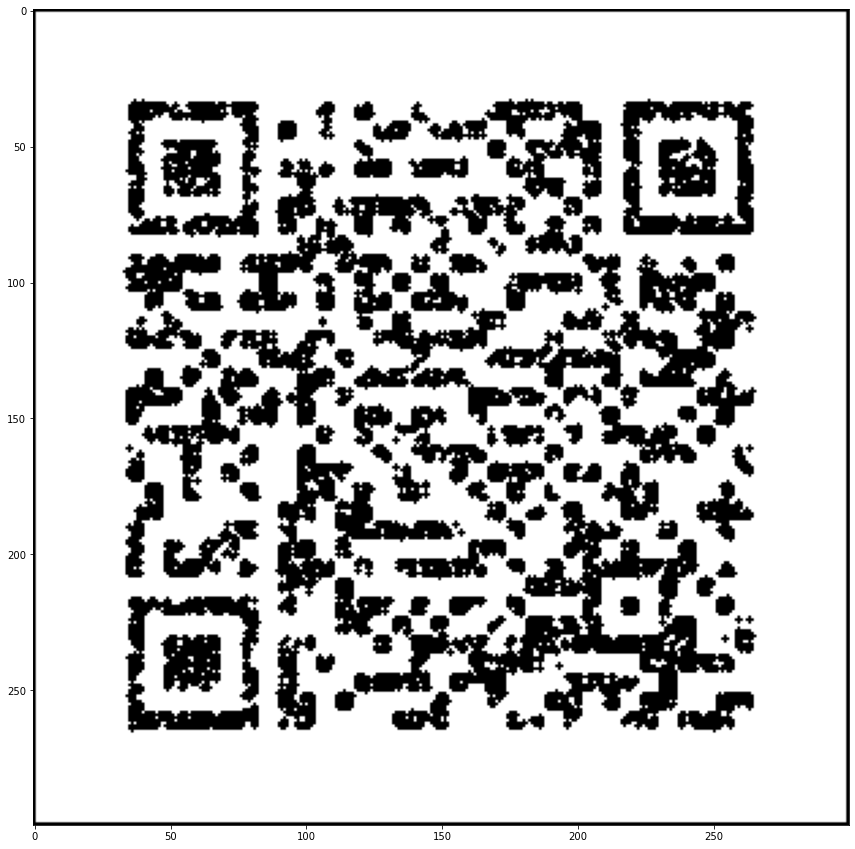

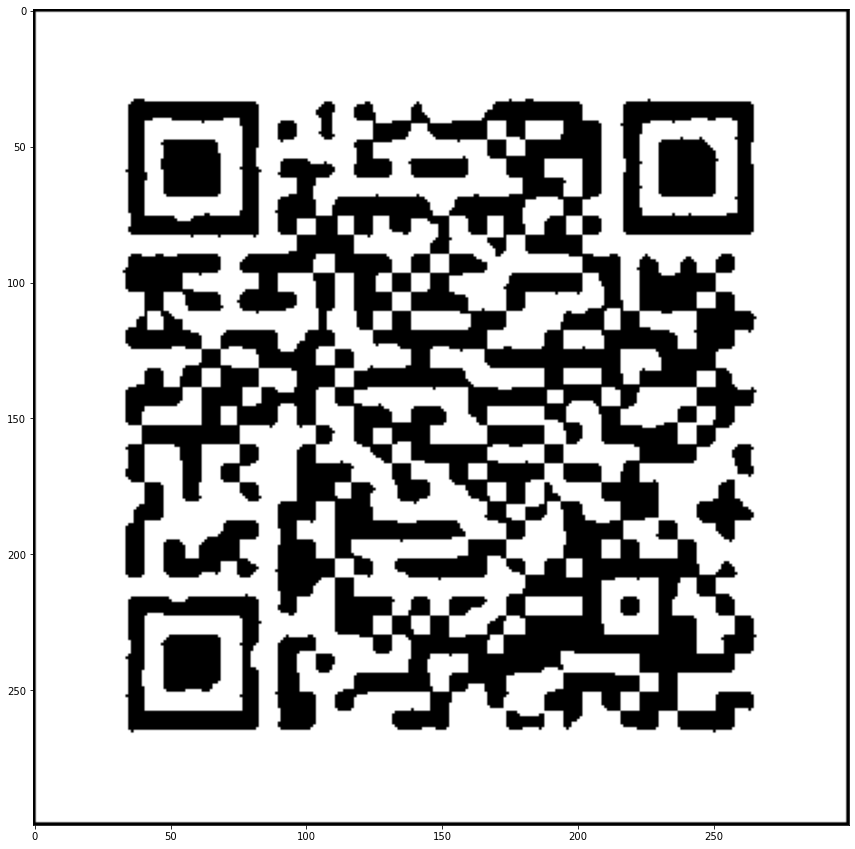

In [15]:
# A compléter
# Traitement du QR Code pour qu'il soit scannable
kernel_cross = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
kernel_rect = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
qr_code_step_1 = closing(qrcode,kernel_cross)
afficher(qr_code_step_1,'gray',figsize=(15,15))
qr_code_traite = opening(qr_code_step_1,kernel_rect)
afficher(qr_code_traite,'gray',figsize=(15,15))

## Rendu de TP
Le rendu qui vous est demandé pour les TP de TIM est la version HTML de ce notebook. Pour l'obtenir: Fichier, télécharger au format, HTML (.html). Avant d'exporter en HTML, veuillez relancer tout votre notebook : Kernel, Redémarrer le kernel et exécuter toutes les cellules